Processing all station files with new cleaning logic...
  -> Successfully processed station 1531300
  -> Successfully processed station 1531450
  -> Successfully processed station 1531550
  -> Successfully processed station 1531600
  -> Successfully processed station 1531800

All station data is now loaded and cleaned!


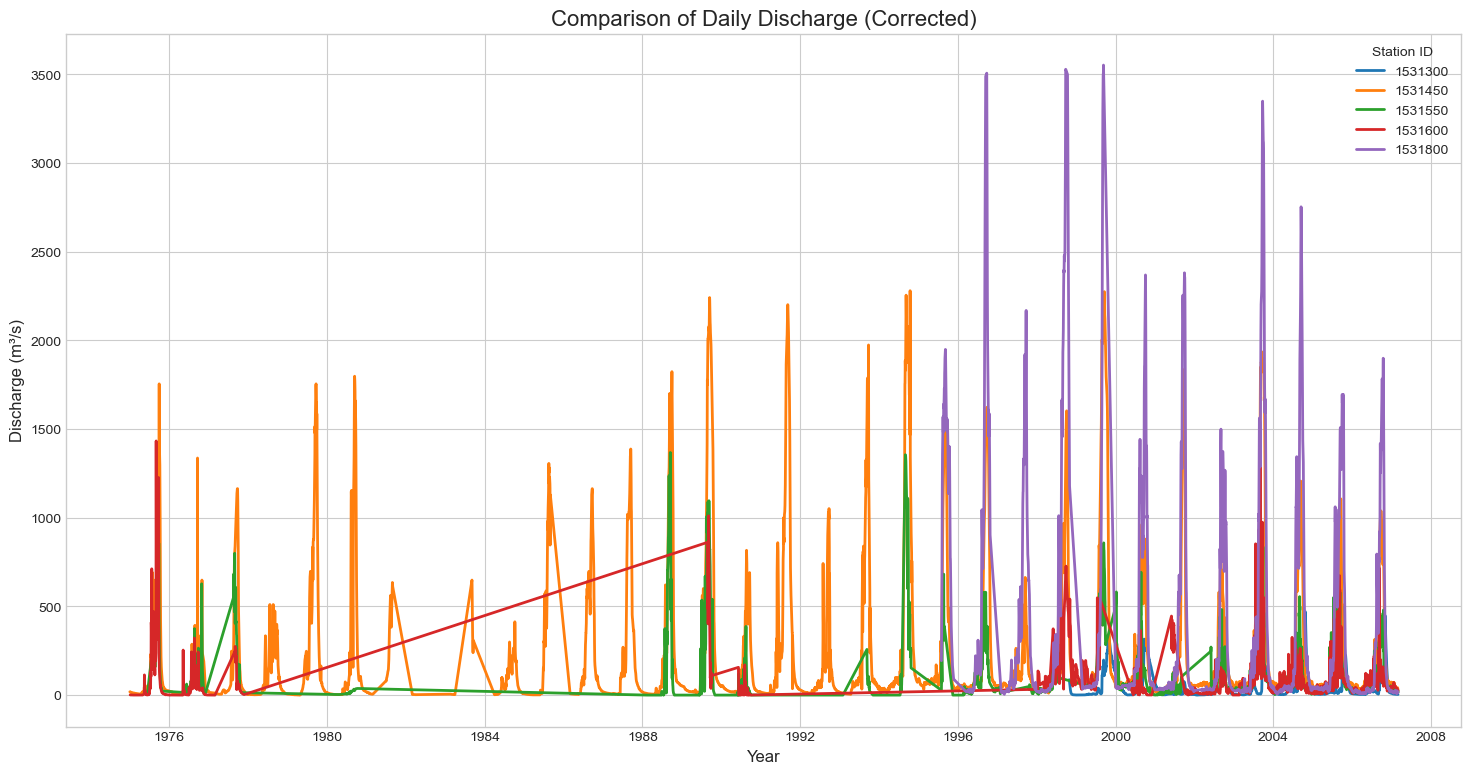

In [6]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np  


def process_grdc_file(file_path):
    """
    Loads a GRDC .Cmd.txt file, cleans it, handles negative
    missing values, and returns a time-series DataFrame.
    """
    try:
        # Read the messy file
        df = pd.read_csv(
            file_path,
            comment='#',
            sep=';',
            header=None,
            names=['date', 'time', 'discharge_m3/s'],
            encoding='latin1'
        )
        
        # The first data row is a junk header, so skip it
        df_clean = df.iloc[1:].copy()
        
        # Drop the empty 'time' column
        df_clean = df_clean.drop(columns=['time'])
        
        # Convert columns to the correct data types
        df_clean['date'] = pd.to_datetime(df_clean['date'])
        # Use errors='coerce' to also catch any non-numeric text
        df_clean['discharge_m3/s'] = pd.to_numeric(df_clean['discharge_m3/s'], errors='coerce') 
        
        # --- THIS IS THE CRITICAL FIX ---
        # 1. Replace all negative values (our missing data code) with NaN
        df_clean.loc[df_clean['discharge_m3/s'] < 0, 'discharge_m3/s'] = np.nan
        
        # 2. Fill the new gaps using linear interpolation
        df_clean['discharge_m3/s'] = df_clean['discharge_m3/s'].interpolate(method='linear')
        # ---------------------------------
        
        # Set the date as the index
        df_clean.set_index('date', inplace=True)
        
        return df_clean
    
    except Exception as e:
        print(f"Error processing {os.path.basename(file_path)}: {e}")
        return None


raw_data_path = '../data/raw/'
station_files = [f for f in os.listdir(raw_data_path) if 'Q_Day.Cmd.txt' in f]

all_stations_df = {}
print("Processing all station files with new cleaning logic...")

for filename in station_files:
    station_id = filename.split('_')[0]
    full_path = os.path.join(raw_data_path, filename)
    
    cleaned_df = process_grdc_file(full_path)
    
    if cleaned_df is not None:
        all_stations_df[station_id] = cleaned_df
        print(f"  -> Successfully processed station {station_id}")

print("\nAll station data is now loaded and cleaned!")


plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(18, 9))

for station_id, df in all_stations_df.items():
    plt.plot(df.index, df['discharge_m3/s'], label=station_id, lw=2)

plt.title('Comparison of Daily Discharge (Corrected)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Discharge (m³/s)', fontsize=12)
plt.legend(title='Station ID')

# Save the new, corrected plot
plt.savefig('../figures/station_comparison_plot_corrected.png', dpi=300)

plt.show()

In [7]:

# Define the file path
soi_path = '../data/raw/soi.long.csv'
df_soi = pd.read_csv(soi_path)

# --- Clean the Data ---
# Clean up column names to remove any hidden whitespace
df_soi.columns = df_soi.columns.str.strip()

# Fix the non-standard date format (e.g., '1866-01-0')
# We take the string, chop off the last character, and add a '1'
date_str_fixed = df_soi['Date'].str[:-1] + '1'
df_soi['date'] = pd.to_datetime(date_str_fixed)

# Automatically find the value column and rename it
value_col_name = [col for col in df_soi.columns if col not in ['Date', 'date']][0]
df_soi = df_soi.rename(columns={value_col_name: 'soi_index'})

# Keep only the columns we need
df_soi = df_soi[['date', 'soi_index']]
df_soi.set_index('date', inplace=True)

# --- Resample to Daily ---
# 'resample("D")' creates a new row for every day.
# '.ffill()' (forward-fill) copies the last known value forward.
df_soi_daily = df_soi.resample('D').ffill()

print("✅ Successfully loaded, cleaned, and resampled SOI data to daily:")
df_soi_daily.head()

✅ Successfully loaded, cleaned, and resampled SOI data to daily:


,soi_index
date,
1866-01-01,-0.62
1866-01-02,-0.62
1866-01-03,-0.62
1866-01-04,-0.62
1866-01-05,-0.62


In [8]:
# =================================================================
# 5. ACQUIRE RAINFALL DATA (Google Earth Engine) - UPDATED
# =================================================================
import ee
import pandas as pd

try:
    # --- THIS IS THE FIX ---
    # Add your Project ID inside the parentheses
    ee.Initialize(project='enduring-trees-475113-j3')
    # ---------------------
except Exception as e:
    ee.Authenticate()
    ee.Initialize(project='enduring-trees-475113-j3') # Add it here too

print("Successfully connected to Google Earth Engine.")

# 1. Define the boundary for the Volta Basin
volta_basin = ee.Geometry.Rectangle([-5.5, 4.5, 2.0, 11.5])

# 2. Load the CHIRPS rainfall dataset
chirps = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY') \
            .filter(ee.Filter.date('1981-01-01', '2023-12-31'))

# 3. This function calculates the average rainfall for each day
def calculate_daily_rainfall(image):
    mean_rainfall = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=volta_basin,
        scale=5566
    ).get('precipitation')
    
    return ee.Feature(None, {
        'date': image.date().format('YYYY-MM-dd'),
        'rainfall_mm': mean_rainfall
    })

# 4. Apply this function
daily_rainfall_features = chirps.map(calculate_daily_rainfall)

# =================================================================
# 6. EXPORT THE DATA (The "Takeout Order")
# =================================================================
task = ee.batch.Export.table.toDrive(
    collection=daily_rainfall_features,
    description='Volta_Basin_Daily_Rainfall_1981_2023',
    fileFormat='CSV'
)

task.start()

print("\n✅ Task submitted successfully!")
print("Please go to the GEE website, click the 'Tasks' tab, and click 'Run' on the new task.")

Successfully connected to Google Earth Engine.

✅ Task submitted successfully!
Please go to the GEE website, click the 'Tasks' tab, and click 'Run' on the new task.


In [9]:
# =================================================================
# 7. LOAD RAINFALL & MERGE ALL DATASETS
# =================================================================

# Load the clean rainfall data from its new home
rainfall_path = '../data/processed/Volta_Basin_Daily_Rainfall_1981_2023.csv'
df_rainfall = pd.read_csv(rainfall_path, index_col='date', parse_dates=True)

# Get our chosen, clean discharge data (it's in memory)
df_discharge = all_stations_df['1531450'].rename(columns={'discharge_m3/s': 'discharge'})

# 'df_soi_daily' is already clean and in memory

# --- Merge our three sources ---
# We use 'how="inner"' to keep only the dates that all 3 datasets have in common.
df_master = df_discharge.join(df_soi_daily, how='inner').join(df_rainfall, how='inner')

# Select only the columns we need (this prevents future errors)
df_master = df_master[['discharge', 'rainfall_mm', 'soi_index']]

print("✅ All three datasets successfully merged:")
df_master.info()

# =================================================================
# 8. FEATURE ENGINEERING
# =================================================================
# This is where we create the "memory" for our model
df_model = df_master.copy()

# 1. Create Lag Features (what happened in the last 7 days)
for i in range(1, 8):
    df_model[f'discharge_lag_{i}'] = df_model['discharge'].shift(i)
    df_model[f'rainfall_lag_{i}'] = df_model['rainfall_mm'].shift(i)

# 2. Create Moving Average Features (what's the recent trend)
df_model['rainfall_ma_7'] = df_model['rainfall_mm'].rolling(window=7).mean()
df_model['rainfall_ma_30'] = df_model['rainfall_mm'].rolling(window=30).mean()

# 3. Create Time-Based Features (what time of year is it)
df_model['month'] = df_model.index.month

# 4. Create the Target Variable (what we want to predict)
# This is the discharge 7 days into the *future*
df_model['target_discharge_t+7'] = df_model['discharge'].shift(-7)

# 5. Clean Up
# Creating lags and targets creates empty (NaN) rows at the start and end.
# We must drop them before we can train a model.
df_model.dropna(inplace=True)

print("\n✅ Feature engineering complete:")
df_model.head()

# =================================================================
# 9. SAVE THE FINAL MODEL-READY DATASET
# =================================================================
# This is the *one* file we will use for all our models.
output_path = '../data/processed/model_ready_data.csv'
df_model.to_csv(output_path)

print(f"\n✅✅✅ PROJECT COMPLETE! Final model-ready data saved to: {output_path}")

✅ All three datasets successfully merged:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9555 entries, 1981-01-01 to 2007-02-28
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   discharge    9555 non-null   float64
 1   rainfall_mm  9555 non-null   float64
 2   soi_index    9555 non-null   float64
dtypes: float64(3)
memory usage: 298.6 KB

✅ Feature engineering complete:

✅✅✅ PROJECT COMPLETE! Final model-ready data saved to: ../data/processed/model_ready_data.csv
